In [ ]:
!pip install tqdm neattext
from wordcloud import WordCloud
import numpy as np 
import pandas as pd
from sklearn.model_selection import train_test_split
!pip install neattext
import neattext.functions as nfx
import matplotlib.pyplot as plt
import plotly.express as plx
from sklearn.metrics import classification_report
import keras
from keras.layers import Embedding,Dense,LSTM,Bidirectional,GlobalMaxPooling1D,Input,Dropout
from keras.callbacks import EarlyStopping,ReduceLROnPlateau
from keras.models import Sequential
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm
import seaborn as sns
import pickle
import warnings
warnings.filterwarnings('ignore')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
data=pd.read_csv('/content/gdrive/MyDrive/garuda/Suicide_Detection.csv')
data.head()

,Unnamed: 0,text,class
0,2,Ex Wife Threatening SuicideRecently I left my ...,suicide
1,3,Am I weird I don't get affected by compliments...,non-suicide
2,4,Finally 2020 is almost over... So I can never ...,non-suicide
3,8,i need helpjust help me im crying so hard,suicide
4,9,"I’m so lostHello, my name is Adam (16) and I’v...",suicide


In [ ]:
data['class'].value_counts()

suicide        116037
non-suicide    116037
Name: class, dtype: int64

In [ ]:
data['class'].value_counts().index.values
data.shape

(232074, 3)

Data Split

In [ ]:
train_data,test_data=train_test_split(data,test_size=0.2,random_state=10)

In [ ]:

def clean_text(text):
    text_length=[]
    cleaned_text=[]
    for sent in tqdm(text):
        sent=sent.lower()
        sent=nfx.remove_special_characters(sent)
        sent=nfx.remove_stopwords(sent)
#         sent=nfx.remove_shortwords(sent)
        text_length.append(len(sent.split()))
        cleaned_text.append(sent)
    return cleaned_text,text_length

In [ ]:
cleaned_train_text,train_text_length=clean_text(train_data.text)
cleaned_test_text,test_text_length=clean_text(test_data.text)


100%|██████████| 46415/46415 [00:02<00:00, 15731.02it/s]


In [ ]:
cleaned_test_text[0]

'anybody photo shopsimply cropping image pasting hand making look legit dm write lot words auto moderator delete post seriously somebody pleaaaaaase helppppp meeeedmmmmm'

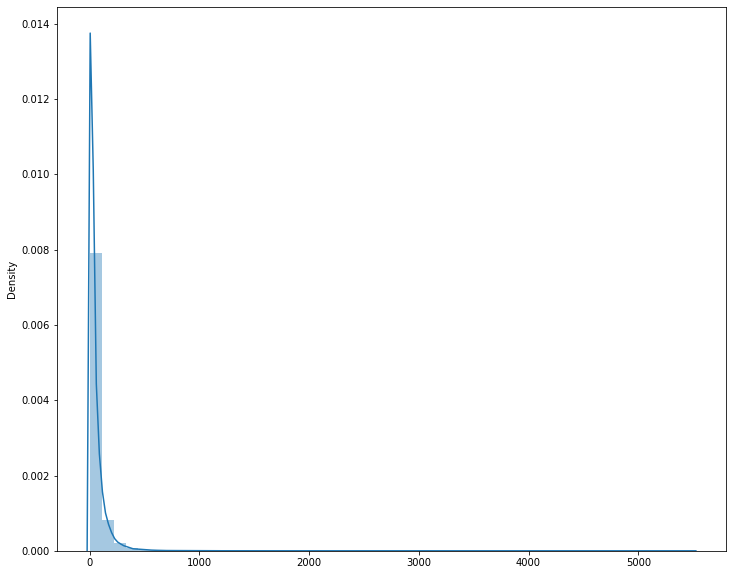

In [ ]:
plt.figure(figsize=(12,10))
sns.distplot(train_text_length)
# plt.axis([-10,100,0,0.03])
plt.show()

In [ ]:
tokenizer=Tokenizer()
tokenizer.fit_on_texts(cleaned_train_text)

In [ ]:
word_freq=pd.DataFrame(tokenizer.word_counts.items(),columns=['word','count']).sort_values(by='count',ascending=False)
word_freq

,word,count
34,im,255049
20,dont,170204
7,like,143392
28,want,118726
27,know,103543
...,...,...
147067,strangersbullies,1
147068,bullshitfast,1
147069,collegework,1
147071,safetywhen,1


In [ ]:
train_text_seq=tokenizer.texts_to_sequences(cleaned_train_text)
train_text_pad=pad_sequences(train_text_seq,maxlen=50)
data=["Am I weird I don't get affected by compliments if it's coming from someone I know irl but I feel really good when internet strangers do it"]
s, _ = clean_text(data)
cleaned_test_text = s
test_text_seq=tokenizer.texts_to_sequences(cleaned_test_text)
test_text_pad=pad_sequences(test_text_seq,maxlen=50)

100%|██████████| 1/1 [00:00<00:00, 961.11it/s]


In [ ]:
test_text_seq

[[277, 2, 1912, 3698, 272, 5, 1411, 6, 22, 556, 1287]]

In [ ]:
lbl_target=LabelEncoder()
train_output=lbl_target.fit_transform(train_data['class'])
test_output=lbl_target.transform(test_data['class'])

Glove Embed

In [ ]:
# glove_embedding={}
with open('../input/pickled-glove840b300d-for-10sec-loading/glove.840B.300d.pkl', 'rb') as fp:
    glove_embedding = pickle.load(fp)

In [ ]:
v=len(tokenizer.word_index)

embedding_matrix=np.zeros((v+1,300), dtype=float)
for word,idx in tokenizer.word_index.items():
    embedding_vector=glove_embedding.get(word)
    if embedding_vector is not None:
        embedding_matrix[idx]=embedding_vector

In [ ]:
early_stop=EarlyStopping(patience=5)
reducelr=ReduceLROnPlateau(patience=3)

Build Model

In [ ]:
model=Sequential()
model.add(Input(shape=(40,)))\
model.add(Embedding(v+1,300,weights=[embedding_matrix],trainable=False))
model.add(LSTM(20,return_sequences=True))
model.add(GlobalMaxPooling1D())
#     model.add(Dropout(0.3))
model.add(Dense(256,activation='relu'))
#     model.add(Dropout(0.2))
model.add(Dense(1,activation='sigmoid'))
model.compile(optimizer=keras.optimizers.SGD(0.1,momentum=0.09),loss='binary_crossentropy',metrics=['accuracy'])

In [ ]:
r=model.fit(train_text_pad,train_output,validation_data=(test_text_pad,test_output),
            epochs=20,batch_size=256,callbacks=[early_stop,reducelr])

Epoch 1/20
726/726 [==============================] - 19s 13ms/step - loss: 0.4612 - accuracy: 0.7741 - val_loss: 0.2982 - val_accuracy: 0.8771
Epoch 2/20
726/726 [==============================] - 9s 12ms/step - loss: 0.2597 - accuracy: 0.8957 - val_loss: 0.2347 - val_accuracy: 0.9067
Epoch 3/20
726/726 [==============================] - 9s 13ms/step - loss: 0.2326 - accuracy: 0.9076 - val_loss: 0.2174 - val_accuracy: 0.9148
Epoch 4/20
726/726 [==============================] - 8s 12ms/step - loss: 0.2202 - accuracy: 0.9132 - val_loss: 0.3076 - val_accuracy: 0.8761
Epoch 5/20
726/726 [==============================] - 9s 12ms/step - loss: 0.2100 - accuracy: 0.9182 - val_loss: 0.3616 - val_accuracy: 0.8521
Epoch 6/20
726/726 [==============================] - 9s 12ms/step - loss: 0.1983 - accuracy: 0.9238 - val_loss: 0.2038 - val_accuracy: 0.9206
Epoch 7/20
726/726 [==============================] - 9s 13ms/step - loss: 0.1837 - accuracy: 0.9289 - val_loss: 0.1891 - val_accuracy: 0.926

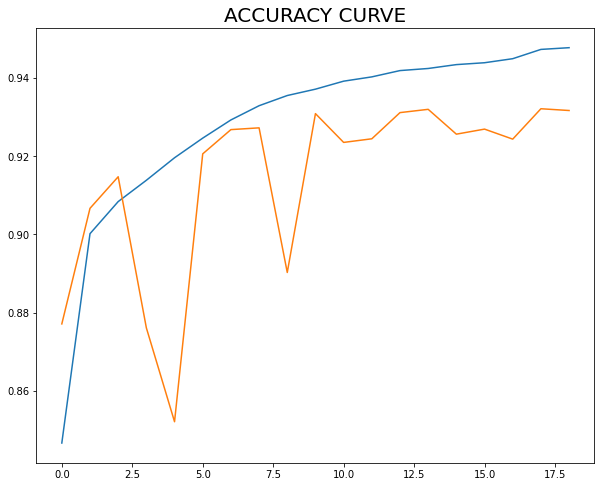

In [ ]:
plt.figure(figsize=(10,8))
plt.plot(r.history['accuracy'])
plt.plot(r.history['val_accuracy'])
plt.title('ACCURACY CURVE',fontdict={'size':20})
plt.show()

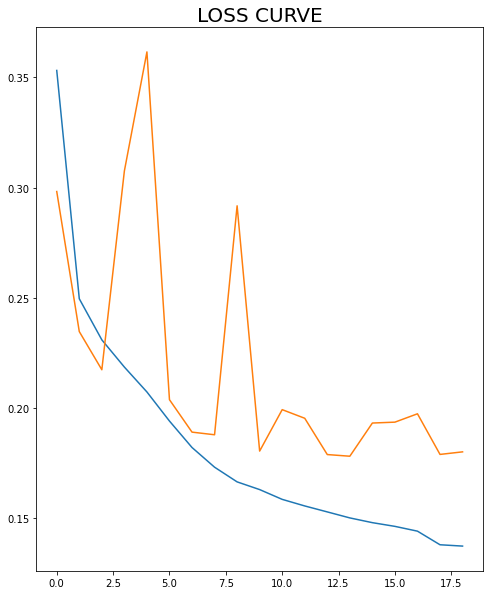

In [ ]:
plt.figure(figsize=(8,10))
plt.plot(r.history['loss'])
plt.plot(r.history['val_loss'])
plt.title('LOSS CURVE',fontdict={'size':20})
plt.show()

In [ ]:
print('TESTING DATA CLASSIFICATION REPORT \n \n')
print(classification_report(test_output,model.predict_classes(test_text_pad),
                            target_names=lbl_target.inverse_transform([0,1])))

print('TRAINING DATA CLASSIFICATION REPORT \n \n')
print(classification_report(train_output,model.predict_classes(train_text_pad),
                           target_names=lbl_target.inverse_transform([0,1])))

TESTING DATA CLASSIFICATION REPORT 
 

              precision    recall  f1-score   support

 non-suicide       0.92      0.95      0.93     23209
     suicide       0.95      0.92      0.93     23206

    accuracy                           0.93     46415
   macro avg       0.93      0.93      0.93     46415
weighted avg       0.93      0.93      0.93     46415

TRAINING DATA CLASSIFICATION REPORT 
 

              precision    recall  f1-score   support

 non-suicide       0.95      0.95      0.95     92828
     suicide       0.95      0.95      0.95     92831

    accuracy                           0.95    185659
   macro avg       0.95      0.95      0.95    185659
weighted avg       0.95      0.95      0.95    185659

